# Summarise the previous results: clean and add the volume and dual computation functions, validate the results


NOTE: What we can mainly see from the results below is that the problem was that some of the dual vertices were 
     not being merged properly (the `if 1:` was turned off before and set to `if 0:` in `compute_vd`)


Test case based on the experiment by Lunowa et al. (2022) _Dynamic Effects during the Capillary Rise of Fluids in Cylindrical Tubes_. 

In [1]:

import math
from scipy.spatial import Delaunay
#import polyscope as ps

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports and physical parameters
# std library

# plotting
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from ddgclib._complex import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._misc import *
from ddgclib._plotting import *

# compute duals (and Delaunay dual from a set of points)
from ddgclib.ddgclib.barycentric import compute_vd, triang_dual

# Plots
from ddgclib.ddgclib.barycentric import plot_dual_mesh_2D, plot_dual_mesh_3D

# Geometry and dual computations

# Boundary geometry                  
from ddgclib.ddgclib.barycentric import  _set_boundary


# Area computations

# Volume computations (including helper functions)


# DDG gradient operations on primary edges (for continuum)

def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points

def plot_complex_3d_mat(points):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.spatial import Delaunay
    
    #np.random.seed(180)
    #points = np.random.rand(10, 3)
    
    tri = Delaunay(points)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(tri.simplices)))
    
    for i, s in enumerate(tri.simplices):
        tetrahedron = points[s]
        facets = [[tetrahedron[0], tetrahedron[1], tetrahedron[2]],
                  [tetrahedron[0], tetrahedron[1], tetrahedron[3]],
                  [tetrahedron[0], tetrahedron[2], tetrahedron[3]],
                  [tetrahedron[1], tetrahedron[2], tetrahedron[3]]]
        collection = Poly3DCollection(facets, alpha=0.1)
        face_color = colors[i]
        collection.set_facecolor(face_color)
        edge_color = (1, 1, 1)  # Make edges less visible
        collection.set_edgecolor(edge_color)
        ax.add_collection3d(collection)
    
        # Plot edges
        edges = [[tetrahedron[0], tetrahedron[1]],
                 [tetrahedron[0], tetrahedron[2]],
                 [tetrahedron[0], tetrahedron[3]],
                 [tetrahedron[1], tetrahedron[2]],
                 [tetrahedron[1], tetrahedron[3]],
                 [tetrahedron[2], tetrahedron[3]]]
        for edge in edges:
            ax.plot3D(*zip(edge[0], edge[1]), color='k', linewidth=0.5)


            

Volume of Parallelepiped=0.16666666666666666


# 2D

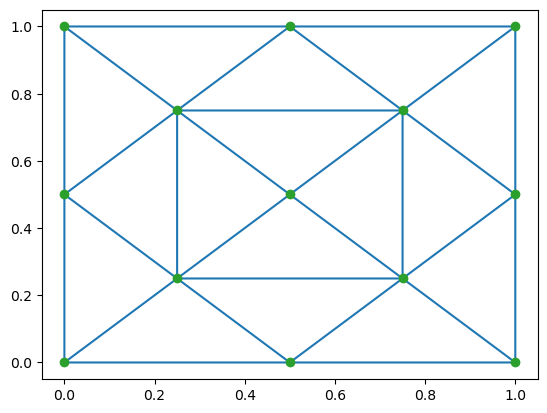

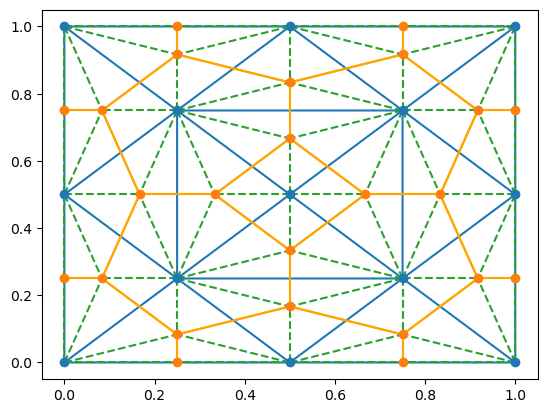

In [2]:
#NOTE: This was moved after defining the code below to validate the 2D:
domain = [(0, 1),]*2

points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
# NEW: Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0) or
        (v.x_a[0] == 1.0 or v.x_a[1] == 1.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv)
    
# Now compute duals as normal   
compute_vd(HC, cdist =1e-10)

plot_dual_mesh_2D(HC, tri, points)

# 3 D


From the paper we expect to reach equilibrium after ∼0.05 s when using the parameters defined in the next cell:

In [3]:
r_list = np.array([0.375, 0.5, 0.65]) *1e-3  # m, Tube radii for 3 experiments
r = 0.5#e-3  # mm (not m!), Default ube radius

gamma = 0.0728  # N/m, surface tension of water at 20 deg C
mu = 0.001  # Pa s, viscosity
rho = 997  # kg/m3, density

g = 9.81  # m/s2
# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
theta_p = 9.99* np.pi/180.0  # Three phase contact angle (degrees immediately converted to radius

# Initial contition
theta_i = 0#2*np.pi  #TODO: Doesn't really do anything yet unless equilibrium is set to True

# Jurin equilibrium height in m:
h_jurin = 2 * gamma * np.cos(theta_p) / (rho * g * r)
h_jurin 




2.9321894204747584e-05

NOTE: From the paper we expect a rise time is roughly 0.3 s

The initial condition is atmospheric pressure at the bottom of the tube (assume the tube is "instantly" inserted and appears below the water line)

The rest of the pressure initial condition should follow rho g h increase.

Different boundary conditions will be explored.

In [4]:
def _cap_rise_meniscus_init(r, theta_i, gamma, N=4, refinement=0,
                            cdist=1e-10, equilibrium=True):
    """
    Helper function to generate the initial film
    :param r: 
    :param theta_i: 
    :param gamma: 
    :param N: 
    :param refinement: 
    :return: 
    """
    Theta = np.linspace(0.0, 2 * np.pi, N)  # range of theta
    R = r / np.cos(theta_i)  # = R at theta = 0
    # Exact values:
    K_f = (1 / R) ** 2
    H_f = 1 / R + 1 / R  # 2 / R
    dp_exact = gamma * (2 / R)  # Pa      # Young-Laplace equation  dp = - gamma * H_f = - gamma * (1/R1 + 1/R2)
    F = []
    nn = []
    F.append(np.array([0.0, 0.0, R * np.sin(theta_i) - R]))
    nn.append([])
    ind = 0
    for theta in Theta:
        ind += 1
        # Define coordinates:
        # x, y, z = sphere(R, theta, phi)
        F.append(np.array([r * np.sin(theta), r * np.cos(theta), 0.0]))
        # Define connections:
        nn.append([])
        if ind > 0:
            nn[0].append(ind)
            nn[ind].append(0)
            nn[ind].append(ind - 1)
            nn[ind].append((ind + 1) % N)

    # clean F
    for f in F:
        for i, fx in enumerate(f):
            if abs(fx) < 1e-15:
                f[i] = 0.0

    F = np.array(F)
    nn[1][1] = ind

    # Construct complex from the initial geometry:
    HC = construct_HC(F, nn)
    v0 = HC.V[tuple(F[0])]
    # Compute boundary vertices
    V = set()
    for v in HC.V:
        V.add(v)
    bV = V - set([v0])
    for i in range(refinement):
        V = set()
        for v in HC.V:
            V.add(v)
        HC.refine_all_star(exclude=bV)
        # New boundary vertices:
        for v in HC.V:
            if v.x[2] == 0.0:
                bV.add(v)

    # Move to spherical cap
    for v in HC.V:
        z = v.x_a[2]
        z_sphere = z - R * np.sin(theta_i)  # move to origin
        # z_sphere = R * np.cos(phi)  # For a sphere centered at origin
        phi_v = np.arccos(z_sphere/R)
        plane_dist = R * np.sin(phi_v)
        # Push vertices on the z-slice the required distance
        z_axis = np.array([0.0, 0.0, z])  # axial centre
        vec = v.x_a - z_axis
        s = np.abs(np.linalg.norm(vec) - plane_dist)
        nvec = normalized(vec)[0]
        nvec = v.x_a + s * nvec
        HC.V.move(v, tuple(nvec))
        vec = nvec - z_axis
        np.linalg.norm(vec)

    # Rebuild set after moved vertices (appears to be needed)
    bV = set()
    for v in HC.V:
        if v.x[2] == 0.0:
            bV.add(v)

    if not equilibrium:
        # Move to zero, for mean flow simulations
        VA = []
        for v in HC.V:
            if v in bV:
                continue
            else:
                VA.append(v.x_a)

        VA = np.array(VA)
        for i, v_a in enumerate(VA):
            v = HC.V[tuple(v_a)]
            v_new = tuple(v.x_a - np.array([0.0, 0.0, v.x_a[2]]))
            HC.V.move(v, v_new)


    return F, nn, HC, bV, K_f, H_f

def cap_rise_init_dyn(r, theta_i, gamma, N=4, refinement=0, depth_dist=0.06, depth_ref=3, cdist=1e-10,
                    equilibrium=True):
    """
    
    :param r: 
    :param theta_i: Initial angle
    :param gamma: 
    :param N: 
    :param refinement: 
    :param cdist: 
    :param equilibrium: 
    :return: 
    """
    F, nn, HC, bV, K_f, H_f = _cap_rise_meniscus_init(r, theta_i, gamma, N, refinement, cdist=1e-10, equilibrium=False)
    
    # Save the points and boundary points
    V_points = []
    bV_points = []
    for v in HC.V:
        V_points.append(v.x_a)
    
    for bv in bV:
        print(f'bv.x_a = {bv.x_a}')
        bV_points.append(bv.x_a)
    
    V_points_film = np.array(V_points)
    bV_points_film = np.array(bV_points)
    print(f'V_points_film.shape = {V_points_film.shape}')
    print(f'bV_points_film.shape = {bV_points_film.shape}')
    # Extend the meniscus film down to a tube below the water line:
    dx = depth_dist/depth_ref
    h = 0  # Height layer tracker
    for i in range(depth_ref):
        # Add new points
        for v in V_points_film:
            v_new = copy.copy(v)
            v_new[2] = v_new[2] + h
            V_points.append(v_new)
            
        # Track new boundary points 
        for bv in bV_points_film:
            bv_new = copy.copy(bv)
            bv_new[2] = bv_new[2] + h
            bV_points.append(bv_new)
            
        h -= dx  # Update next layer height
        
    V_points = np.array(V_points)
    bV_points_a = np.array(bV_points)
    
    # Reconstruct the complex using these values:
    HC = Complex(3)
    for va in V_points:
        v = HC.V[tuple(va)]
        # Set default boundary off
        v.boundary = False

    
    tri = Delaunay(V_points)
    plot_complex_3d_mat(V_points)
    for t in tri.simplices:
        for v1i in t:
            v1a = V_points[v1i]
            v1 = HC.V[tuple(v1a)]
            for v2i in t:
                v2a =  V_points[v2i]
                v2 = HC.V[tuple(v2a)]
                v1.connect(v2)
    
    # Add boundary conditions:
    if 0:
        for vba in bV_points_a:
            vb = HC.V[tuple(vba)]
            vb.boundary = True
        
        # All the top and bottom points must also be boundary points (in the future use boundary function):
    
        h += dx  # Reset height to last layer in loop
        for v in V_points_film:
            v_new = copy.copy(v)
            v1 = HC.V[tuple(v_new)]
            v1.boundary = True
            v_new[2] = v_new[2] + h
            v2 = HC.V[tuple(v_new)]
            v2.boundary = True
            bV_points.append(v1.x_a)
            bV_points.append(v2.x_a)
    
        bV_points = np.array(bV_points)
        print(f'V_points.shape = {V_points.shape}')
        print(f'bV_points.shape = {bV_points.shape}')
    
    # Clean up:
    HC.V.merge_all(cdist)
    
    bV = set()
    for vba in bV_points:
        vb = HC.V[tuple(vba)]
        bV.add(vb)
    print(f'bV = {bV}')
    return HC, bV

In [5]:
# New function:
def merge_local_duals_vector(x_a_l, Vd_cache, cdist=1e-10):
    """
    For a proposed new vertex position, first check the local dual cache
    of vertices for a similar position, if one is found, use that exact
    position instead to avoid generating duplicate dual vetices.
    
    This is needed due to overflow errors giving slightly different results
    and therefore producing multiple keys for the same dual.
    
    :param x_a: List of vectors of new vertex position
    :param Vd_cache: iterable object of local dual vertices
    :param cdist: scalar, tolerance of identifying dual vertices
    :return: 
    """
    for vd_i in Vd_cache:
        for i, x_a in enumerate(x_a_l):
            dist = np.linalg.norm(vd_i.x_a - x_a)
            if dist < cdist:
                x_a_l[i] = vd_i.x_a
                
    return x_a_l
    


def compute_vd(HC, cdist=1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.

    Currently only dim = 2, 3 is supported

    cdist: float, tolerance for where a unique dual vertex can exist

    """
    #TODO: Merging the dual vertices is probably inefficient, it might 
    # actually be more efficient to do one global merge of the vertices
    # after the routine has finished instead.
    # Construct dual cache
    HC.Vd = VertexCacheField()

    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()

    # hcv = copy.copy(HC.V)
    if HC.dim == 2:
        for v1 in HC.V:
            for v2 in v1.nn:
                # If boundary vertex, we stop and generate a new vertex on the boundary edge.
                try:
                    if v1.boundary and v2.boundary:
                        cd = v1.x_a + 0.5 * (v2.x_a - v1.x_a)
                        vd = HC.Vd[tuple(cd)]
                        v1.vd.add(vd)
                        v2.vd.add(vd)
                        # Connect to dual simplex
                        v1nn_u_v2nn = v1.nn.intersection(v2.nn)  # Should always be length 1
                        v3 = list(v1nn_u_v2nn)[0]
                        verts = np.zeros([3, HC.dim])
                        verts[0] = v1.x_a
                        verts[1] = v2.x_a
                        verts[2] = v3.x_a
                        cd1 = np.mean(verts, axis=0)
                        vd1 = HC.Vd[tuple(cd1)]
                        # Connect the two dual vertices forming the boundary dual edge:
                        vd.connect(vd1)
                        continue
                except AttributeError:
                    pass
                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)  # Should always be length 2
                # In 2D there are only two
                v3_1 = list(v1nn_u_v2nn)[0]
                v3_2 = list(v1nn_u_v2nn)[1]
                if (v3_1 is v1) or (v3_2 is v1):
                    continue
                verts = np.zeros([3, HC.dim])
                verts[0] = v1.x_a
                verts[1] = v2.x_a
                verts[2] = v3_1.x_a
                # Compute the circumcentre:
                # cd = circumcenter(verts)
                # Compute the barycentre of the first connected triangle sharing primary edge/face e_1e:
                cd1 = np.mean(verts, axis=0)

                # Compute the barycentre of the first connected triangle sharing primary edge/face e_1e:
                verts[2] = v3_2.x_a
                cd2 = np.mean(verts, axis=0)
                # Note instead of below, could round off cd in general to say nearest 1e-12
                # Check for uniqueness first (new, expensive, could
                # be improved by checking duals of neighbours only?):
                for vd_i in HC.Vd:
                    dist1 = np.linalg.norm(vd_i.x_a - cd1)
                    dist2 = np.linalg.norm(vd_i.x_a - cd2)
                    if dist1 < cdist:
                        cd1 = vd_i.x_a
                    if dist2 < cdist:
                        cd2 = vd_i.x_a

                vd1 = HC.Vd[tuple(cd1)]
                vd2 = HC.Vd[tuple(cd2)]
                # Connect the two dual vertices:
                vd1.connect(vd2)

                # Connect to all primal vertices of v3_1 dual
                for v in [v1, v2, v3_1]:
                    v.vd.add(vd1)

                # Connect to all primal vertices of v3_2 dual
                for v in [v1, v2, v3_2]:
                    v.vd.add(vd2)

    elif HC.dim == 3:
        for v1 in HC.V:
            for v2 in v1.nn:
                # Note: every boundary primary edge only has two boundary tetrahedra connected
                # and therefore only two barycentric dual points. We do not need to connect with
                # other duals therefore simply connect to the primary edges.
                
                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)
                for v3 in v1nn_u_v2nn:
                    print('-')
                    if (v3 is v1):
                        continue
                        
                    v1nn_u_v2nn_u_v3nn = v1nn_u_v2nn.intersection(v3.nn)  # Should be length 2, unless the triangle is on the boundary
                    print(f'v1.x = {v1.x}')
                    print(f'v2.x = {v2.x}')
                    print(f'v3.x = {v3.x}')
                    v4_1 = list(v1nn_u_v2nn_u_v3nn)[0]
                    #v4_2 = list(v1nn_u_v2nn_u_v3nn)[1]
                    
                    #if (v4_1 is v1) or (v4_1 is v2) or (v4_2 is v1) or (v4_2 is v2):
                    #    continue
                    
                    # debug above, should never occur?:
                    if 1:
                        if (v4_1 is v1) or (v4_1 is v2):
                            print(f'WARNING (v4_1 is v1) or (v4_1 is v2)')

                    # Compute the two duals of tetrahedra connected by face f_123 of triangle [v1, v2, v3]
                    verts = np.zeros([HC.dim + 1, HC.dim])
                    verts[0] = v1.x_a  # TODO: Added 08.03.24, investigate accidental deletion?
                    verts[1] = v2.x_a
                    verts[2] = v3.x_a
                    verts[3] = v4_1.x_a
                    #  Compute the barycentre of the first connected simplex sharing primary face f_123:
                    cd1 = np.mean(verts, axis=0)
                    
                    # If v123 is on the boundary then we instead want to generate the barycenter
                    # dual vd123 and then connect it to edge dual vd12 and cd1
                    if (v1.boundary and v2.boundary) and v3.boundary:
                        # debug print:
                        if len(list(v1nn_u_v2nn_u_v3nn)) > 1:
                            print(f'WARNING: len(list(v1nn_u_v2nn_u_v3nn)) = {len(list(v1nn_u_v2nn_u_v3nn))} which is > expected 1')
                        
                        #verts_b = np.zeros([3, HC.dim]) 
                        verts_b = verts[:3]
                        cd2 = np.mean(verts_b, axis=0)
                        
                        # Connect the dual of e_12 primal edge vertices
                        cd12 = v1.x_a + 0.5 * (v2.x_a - v1.x_a)
                        vd12 = HC.Vd[tuple(cd12)]
                        v1.vd.add(vd12)
                        v2.vd.add(vd12)
                        
                    # Compute the barycentre of the second connected simplex sharing primary face f_123:
                    else:
                        v4_2 = list(v1nn_u_v2nn_u_v3nn)[1]
                        verts[3] = v4_2.x_a
                        cd2 = np.mean(verts, axis=0)
                        
                        # debug above, should never occur?:
                        if 1:
                            if (v4_2 is v1) or (v4_2 is v2):
                                print(f'WARNING (v4_1 is v1) or (v4_1 is v2)')

                    # Note instead of below, could round off cd in general to say nearest 1e-12
                    # Check for uniqueness first (new, expensive, could
                    # be improved by checking duals of neighbours only?):
                    if 1:
                        for vd_i in HC.Vd:
                            dist1 = np.linalg.norm(vd_i.x_a - cd1)
                            dist2 = np.linalg.norm(vd_i.x_a - cd2)
                            if dist1 < cdist:
                                cd1 = vd_i.x_a
                            if dist2 < cdist:
                                cd2 = vd_i.x_a

                    #  Define the new dual vertices
                    vd1 = HC.Vd[tuple(cd1)]
                    vd2 = HC.Vd[tuple(cd2)]
                    # Connect the two dual vertices:
                    vd1.connect(vd2)

                    # Connect to all primal vertices of v3_1 dual
                    for v in [v1, v2, v3, v4_1]:
                        v.vd.add(vd1)

                    # Connect to all primal vertices of v3_2 dual
                    if (v1.boundary and v2.boundary) and v3.boundary:
                        for v in [v1, v2, v3]:  # v4_2 doesn't exist on boundary face
                            v.vd.add(vd2)
                    else:
                        for v in [v1, v2, v3, v4_2]:
                            v.vd.add(vd2)


    return HC  # self

def plot_dual(v, HC, vector_field=None, scalar_field=None, fn='', up="x_up"
              , stl=False):
    v1 = v
    # Initialize polyscope
    ps.init()
    ps.set_up_dir('z_up')
    do = coldict['do']
    lo = coldict['lo']
    db = coldict['db']
    lb = coldict['lb']
    tg = coldict['tg']  # Tab:green colour
    # %% Plot Barycentric dual mesh
    # Loop over primary edges
    dual_points_set = set()
    ssets = []  # Sets of simplices
    v1 = v
    for i, v2 in enumerate(v1.nn):
        # Find the dual vertex of e12:
        vc_12 = 0.5 * (v2.x_a - v1.x_a) + v1.x_a  # TODO: Should be done in the compute_vd function
        vc_12 = HC.Vd[tuple(vc_12)]

        # Find local dual points intersecting vertices terminating edge:
        dset = v2.vd.intersection(v1.vd)  # Always 5 for boundaries
        # Start with the first vertex and then build triangles, loop back to it:
        vd_i = list(dset)[0]
        if v1.boundary and v2.boundary:
            print(f'len(dset) = {len(dset)}')
            # Remove the boundary edge which should already be in the set:
            if not (len(vd_i.nn.intersection(dset)) == 1):
                for vd in dset:
                    vd_i = vd
                    if len(vd_i.nn.intersection(dset)) == 1:
                        break
            #iter_len = 3
            # The set length much be different because all interior planes
            # are counted minus two boudary vertices which do not form triangles
            # such as the flux planes in the bulk
            iter_len = len(list(dset)) - 2 
        else:
            iter_len = len(list(dset))
        
        
        # Main loop
        dsetnn = vd_i.nn.intersection(dset)  # Always 1 internal dual vertices
        vd_j = list(dsetnn)[0]
        # NOTE: In the boundary edges the last triangle does not have
        #      a final vd_j
        #print(f'dset = {dset}')
        for _ in range(iter_len):  # For boundaries should be length 2?
            ssets.append([vc_12, vd_i, vd_j])
            dsetnn_k = vd_j.nn.intersection(dset)  # Always 2 internal dual vertices in interior
            #print(f'dsetnn_k = {dsetnn_k}')
            dsetnn_k.remove(vd_i)  # Should now be size 1
            vd_i = vd_j
            try:
                # Alternatively it should produce an IndexError only when
                # _ = 2 (end of range(3) and we are on a boundary edge
                # so that (v1.boundary and v2.boundary) is true
                vd_j = list(dsetnn_k)[0]  # Retrieve the next vertex
            except IndexError:
                pass  # Should only happen for boundary edges

        # Find local dual points intersecting vertices terminating edge:
        dset = v2.vd.intersection(v1.vd)
        pi = []
        for vd in dset:
            # pi.append(vd.x + 1e-9 * np.random.rand())
            pi.append(vd.x)
            dual_points_set.add(vd.x)
        pi = np.array(pi)
        pi_2d = pi[:, :2] + 1e-9 * np.random.rand()

        # Plot dual points:
        dual_points = []
        for vd in dual_points_set:
            dual_points.append(vd)

        dual_points = np.array(dual_points)
        ps_cloud = ps.register_point_cloud("Dual points", dual_points)
        ps_cloud.set_color(do)

    # Build the simplices for plotting
    faces = []
    vdict = collections.OrderedDict()  # Ordered cache of vertices to plot
    ind = 0
    # Now iterate through all the constructed simplices and find indexes
    for s in ssets:
        f = []
        for v in s:
            if not (v.x in vdict):
                vdict[v.x] = ind
                ind += 1

            f.append(vdict[v.x])
        faces.append(f)

    verts = np.array(list(vdict.keys()))
    faces = np.array(faces)

    dsurface = ps.register_surface_mesh(f"Dual face {i}", verts, faces,
                                        color=do,
                                        edge_width=0.0,
                                        edge_color=(0.0, 0.0, 0.0),
                                        smooth_shade=False)

    # Plot primary mesh
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)

    # %% Register the primary vertices as a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("Primary points", my_points)
    ps_cloud.set_color(tuple(db))
    # ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    if stl:
        #  msh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
        for i, f in enumerate(faces):
            for j in range(3):
                pass
                # msh.vectors[i][j] = verts[f[j], :]

        # msh.save(f'{fn}.stl')

    ### Plot the primary mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    if 1:
        surface = ps.register_surface_mesh("Primary surface", verts, faces,
                                           color=db,
                                           edge_width=1.0,
                                           edge_color=(0.0, 0.0, 0.0),
                                           smooth_shade=False)

        surface.set_transparency(0.3)
        # Add a scalar function and a vector function defined on the mesh
        # vertex_scalar is a length V numpy array of values
        # face_vectors is an Fx3 array of vectors per face

        # View the point cloud and mesh we just registered in the 3D UI
        # ps.show()
        # Plot particles
        # Ground plane options
        ps.set_ground_plane_mode("shadow_only")  # set +Z as up direction
        ps.set_ground_plane_height_factor(0.1)  # adjust the plane height
        ps.set_shadow_darkness(0.2)  # lighter shadows
        ps.set_shadow_blur_iters(2)  # lighter shadows
        ps.set_transparency_mode('pretty')
        # ps.look_at((0., -10., 0.), (0., 0., 0.))
        ps.look_at((1., -8., -8.), (0., 0., 0.))
        # ps.set_ground_plane_height_factor(x, is_relative=True)
        ps.set_screenshot_extension(".png")
        # Take a screenshot
        # It will be written to your current directory as screenshot_000000.jpg, etc
        ps.screenshot(fn)
    return ps



In [6]:
%matplotlib notebook

def cube_to_tube(r, refinements=1):
    
    # Construct the intial cube 
    lb = -1.0#e-6
    ub = 1.0#e-6
    lb = -0.5#e-6
    ub = 0.5#e-6
    domain = [(lb, ub),]*3
    #symmetry = [0, 1, 1]
    HC = Complex(3, domain=domain, symmetry=None)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()
        
    
    # NEW
    # Compute boundaries
    bV = set()
    for v in HC.V:
        if ((v.x_a[0] == lb or v.x_a[1] == lb or v.x_a[2] == lb) or
            (v.x_a[0] == ub or v.x_a[1] == ub or v.x_a[2] == ub)):
            bV.add(v)
            
    for bv in bV:
        _set_boundary(bv, True)
    for v in HC.V:
        if not (v in bV):
            _set_boundary(v, False)

    # Move the vertices to the tube radius
    for v in HC.V:
        # The initial cube has centre 0.0, 0.0, 0.0
        #d = np.zeros(2)
        d = np.linalg.norm(v.x_a[:2]) 
        if d > 1.0:
            d = 1.0
        #r_eff = 0.1*d * r  # Trancated radius projection    
        r_eff = d * r  # Trancated radius projection    
        nv = np.zeros(3)
        theta = math.atan2(v.x_a[1] , v.x_a[0])
        nv[0] = r_eff * np.sin(theta)
        nv[1] = r_eff * np.cos(theta)
        nv[2] = v.x[2]
        #HC.V.move(v, tuple(nv))
        #HC.V.move(v, tuple(0.5*v.x_a))
        
    return HC

HC = cube_to_tube(r, refinements=1)
#compute_vd(HC, cdist =1e-10)
print(f'HC.len = {HC.V.size()}')
HC.plot_complex()

HC.len = 35


<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, <Axes3D: >, None, None)

In [7]:
HC.dim

3

In [8]:
HC.V.print_out()

Vertex cache of size: 35:
Vertex: (-0.5, -0.5, -0.5)
Connections: (-0.5, -0.5, 0.0) (0.0, 0.0, -0.5) (-0.25, -0.25, -0.25) (0.0, -0.5, -0.5) (0.0, -0.5, 0.0) (-0.5, 0.0, 0.0) (-0.5, 0.0, -0.5) 
Vertex: (0.5, 0.5, 0.5)
Connections: (0.5, 0.0, 0.5) (0.0, 0.0, 0.5) (0.0, 0.5, 0.5) (0.5, 0.5, 0.0) (0.25, 0.25, 0.25) (0.0, 0.5, 0.0) (0.5, 0.0, 0.0) 
Vertex: (0.5, -0.5, -0.5)
Connections: (0.5, 0.0, 0.0) (0.25, -0.25, -0.25) (0.5, -0.5, 0.0) (0.0, 0.0, -0.5) (0.0, -0.5, -0.5) (0.0, -0.5, 0.0) (0.5, 0.0, -0.5) 
Vertex: (-0.5, 0.5, -0.5)
Connections: (0.0, 0.0, -0.5) (-0.25, 0.25, -0.25) (-0.5, 0.0, 0.0) (-0.5, 0.5, 0.0) (0.0, 0.5, 0.0) (-0.5, 0.0, -0.5) (0.0, 0.5, -0.5) 
Vertex: (0.5, 0.5, -0.5)
Connections: (0.5, 0.0, 0.0) (0.0, 0.0, -0.5) (0.0, 0.5, 0.0) (0.5, 0.5, 0.0) (0.25, 0.25, -0.25) (0.0, 0.5, -0.5) (0.5, 0.0, -0.5) 
Vertex: (-0.5, -0.5, 0.5)
Connections: (-0.5, -0.5, 0.0) (0.0, 0.0, 0.5) (-0.25, -0.25, 0.25) (0.0, -0.5, 0.0) (0.0, -0.5, 0.5) (-0.5, 0.0, 0.5) (-0.5, 0.0, 0.0) 
Vertex

In [9]:
#compute_vd(HC, cdist=1e-12)
compute_vd(HC, cdist=1e-100)

-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.5, -0.5, 0.0)
v3.x = (0.0, -0.5, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.5, -0.5, 0.0)
v3.x = (-0.5, 0.0, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.5, -0.5, 0.0)
v3.x = (-0.25, -0.25, -0.25)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0, 0.0, -0.5)
v3.x = (0.0, -0.5, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0, 0.0, -0.5)
v3.x = (-0.5, 0.0, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0, 0.0, -0.5)
v3.x = (-0.25, -0.25, -0.25)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (-0.5, -0.5, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (0.0, 0.0, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (0.0, -0.5, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (0.0, -0.5, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (-0.5, 0.0, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (-0.5, 0.0, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0,

In [10]:
for v in HC.V:
    for vd in v.vd:
        print(vd.x)
    #print(v.x_a)

(-0.5, -0.5, -0.25)
(-0.16666666666666666, -0.3333333333333333, -0.5)
(-0.1875, -0.4375, -0.3125)
(-0.5, -0.3333333333333333, -0.16666666666666666)
(-0.3333333333333333, -0.16666666666666666, -0.5)
(-0.5, -0.16666666666666666, -0.3333333333333333)
(-0.3125, -0.4375, -0.1875)
(-0.25, -0.25, -0.5)
(-0.4375, -0.1875, -0.3125)
(-0.25, -0.5, -0.25)
(-0.3125, -0.1875, -0.4375)
(-0.5, -0.25, -0.5)
(-0.16666666666666666, -0.5, -0.3333333333333333)
(-0.3333333333333333, -0.5, -0.16666666666666666)
(-0.1875, -0.3125, -0.4375)
(-0.25, -0.5, -0.5)
(-0.5, -0.25, -0.25)
(-0.4375, -0.3125, -0.1875)
(0.3333333333333333, 0.16666666666666666, 0.5)
(0.25, 0.5, 0.5)
(0.4375, 0.1875, 0.3125)
(0.5, 0.16666666666666666, 0.3333333333333333)
(0.3125, 0.4375, 0.1875)
(0.25, 0.5, 0.25)
(0.5, 0.3333333333333333, 0.16666666666666666)
(0.1875, 0.4375, 0.3125)
(0.3125, 0.1875, 0.4375)
(0.4375, 0.3125, 0.1875)
(0.5, 0.25, 0.5)
(0.16666666666666666, 0.3333333333333333, 0.5)
(0.16666666666666666, 0.5, 0.333333333333333

In [11]:
HC.V.size()

35

In [12]:
for v in HC.V:
    print(len(v.nn))

7
7
7
7
7
7
7
7
26
7
13
7
7
7
13
7
7
7
7
13
13
13
13
7
7
7
7
8
8
8
8
8
8
8
8


In [13]:
for v in HC.V:
    #print(v.x)
    print(v.boundary)

True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False


In [14]:
# Add dual points
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
#plot_dual_mesh_3D(HC, dual_points)

In [15]:
vi = HC.V[(0.0, 0.0, 0.0)]
print(f'len(vi.vd) = {len(vi.vd)}')
for vd in vi.vd:
    print(f'vd.x = {vd.x}')
    
print(f'len(vi.nn) = {len(vi.nn)}') 

len(vi.vd) = 48
vd.x = (-0.0625, -0.1875, -0.3125)
vd.x = (-0.0625, -0.1875, 0.3125)
vd.x = (-0.3125, -0.1875, 0.0625)
vd.x = (-0.3125, -0.1875, -0.0625)
vd.x = (0.1875, 0.3125, -0.0625)
vd.x = (-0.1875, -0.0625, -0.3125)
vd.x = (-0.1875, -0.0625, 0.3125)
vd.x = (0.1875, 0.3125, 0.0625)
vd.x = (0.1875, -0.3125, -0.0625)
vd.x = (0.1875, -0.3125, 0.0625)
vd.x = (-0.3125, -0.0625, -0.1875)
vd.x = (0.3125, -0.1875, -0.0625)
vd.x = (0.3125, -0.1875, 0.0625)
vd.x = (0.0625, -0.1875, -0.3125)
vd.x = (-0.3125, -0.0625, 0.1875)
vd.x = (-0.1875, 0.0625, -0.3125)
vd.x = (-0.1875, 0.0625, 0.3125)
vd.x = (0.0625, 0.1875, -0.3125)
vd.x = (0.0625, 0.1875, 0.3125)
vd.x = (-0.3125, 0.0625, -0.1875)
vd.x = (0.3125, -0.0625, -0.1875)
vd.x = (0.3125, -0.0625, 0.1875)
vd.x = (-0.3125, 0.0625, 0.1875)
vd.x = (-0.0625, 0.1875, -0.3125)
vd.x = (-0.0625, 0.1875, 0.3125)
vd.x = (0.1875, -0.0625, -0.3125)
vd.x = (0.1875, -0.0625, 0.3125)
vd.x = (0.0625, 0.3125, -0.1875)
vd.x = (0.0625, 0.3125, 0.1875)
vd.x = (-0

In [16]:
plot_dual(vi, HC)
import polyscope as ps
#ps.set_autocenter_structures(True)
#ps.set_autoscale_structures(True)
#ps.set_length_scale(1e3)
ps.show()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 555.58


In [17]:
HC.dim

2

In [18]:
def move_new(V, v, x):
    #TODO: We should also update the indices!
    V.cache.pop(v.x)
    #del(HC.V.cache[v.x])

    # Note that we need to remove the object from the nn sets since the hash
    # value is changed although the object stays the same.
    vn = copy.copy(v.nn)
    for vn_i in vn:
        v.disconnect(vn_i)

    v.x = x
    v.hash = hash(x)
    try:
        v.x_a = np.array(x, dtype=np.longdouble)
    except AttributeError:
        pass

    V.cache[x] = v
    # Reconnect new hashes
    for vn_i in vn:
        v.connect(vn_i)
   
    return V.cache[x]

In [19]:
print(f'len(vi.nn) = {len(vi.nn)}') 
print(f'len(vi.vd) = {len(vi.vd)}') 
old_Vd_size = HC.Vd.size()
print(f'HC.Vd.size() = {HC.Vd.size()}')

len(vi.nn) = 26
len(vi.vd) = 48
HC.Vd.size() = 242


In [20]:
# Now move the vertex and see if the neighbouring sets are the same:
vt_new = (1e-5, 1e-5, 1e-5)
#vt_new = (1e-1, 1e-1, 1e-1)
#vt_new = (0,0, 0)
v_new = HC.V.move(vi, vt_new)

In [21]:
for v in HC.V:
    print(v.x)

(-0.5, -0.5, -0.5)
(0.5, 0.5, 0.5)
(0.5, -0.5, -0.5)
(-0.5, 0.5, -0.5)
(0.5, 0.5, -0.5)
(-0.5, -0.5, 0.5)
(0.5, -0.5, 0.5)
(-0.5, 0.5, 0.5)
(0.0, -0.5, -0.5)
(0.0, 0.0, -0.5)
(-0.5, 0.0, -0.5)
(0.5, 0.0, -0.5)
(0.0, 0.5, -0.5)
(0.0, 0.0, 0.5)
(-0.5, -0.5, 0.0)
(0.5, -0.5, 0.0)
(-0.5, 0.5, 0.0)
(0.5, 0.5, 0.0)
(0.0, -0.5, 0.0)
(-0.5, 0.0, 0.0)
(0.5, 0.0, 0.0)
(0.0, 0.5, 0.0)
(0.0, -0.5, 0.5)
(-0.5, 0.0, 0.5)
(0.5, 0.0, 0.5)
(0.0, 0.5, 0.5)
(-0.25, -0.25, -0.25)
(-0.25, -0.25, 0.25)
(0.25, -0.25, -0.25)
(0.25, -0.25, 0.25)
(0.25, 0.25, -0.25)
(-0.25, 0.25, -0.25)
(-0.25, 0.25, 0.25)
(0.25, 0.25, 0.25)
(1e-05, 1e-05, 1e-05)


In [22]:
HC.dim = 3

In [23]:
for v in HC.V:
    v.vd = set()
    print(v.x)
 

(-0.5, -0.5, -0.5)
(0.5, 0.5, 0.5)
(0.5, -0.5, -0.5)
(-0.5, 0.5, -0.5)
(0.5, 0.5, -0.5)
(-0.5, -0.5, 0.5)
(0.5, -0.5, 0.5)
(-0.5, 0.5, 0.5)
(0.0, -0.5, -0.5)
(0.0, 0.0, -0.5)
(-0.5, 0.0, -0.5)
(0.5, 0.0, -0.5)
(0.0, 0.5, -0.5)
(0.0, 0.0, 0.5)
(-0.5, -0.5, 0.0)
(0.5, -0.5, 0.0)
(-0.5, 0.5, 0.0)
(0.5, 0.5, 0.0)
(0.0, -0.5, 0.0)
(-0.5, 0.0, 0.0)
(0.5, 0.0, 0.0)
(0.0, 0.5, 0.0)
(0.0, -0.5, 0.5)
(-0.5, 0.0, 0.5)
(0.5, 0.0, 0.5)
(0.0, 0.5, 0.5)
(-0.25, -0.25, -0.25)
(-0.25, -0.25, 0.25)
(0.25, -0.25, -0.25)
(0.25, -0.25, 0.25)
(0.25, 0.25, -0.25)
(-0.25, 0.25, -0.25)
(-0.25, 0.25, 0.25)
(0.25, 0.25, 0.25)
(1e-05, 1e-05, 1e-05)


In [24]:
HcVd = copy.copy(HC.Vd)
for vd in HcVd:
    print(f'vd.x = {vd.x}')
    HC.Vd.cache.pop(vd.x)
    #del(HC.Vd.cache[vd.x])
    print(f'len(HC.Vd.cache) = {len(HC.Vd.cache)}')
print(id(HC.Vd.cache))  # Compare this in different parts of the code



vd.x = (-0.5, -0.5, -0.25)
len(HC.Vd.cache) = 241
vd.x = (-0.3125, -0.4375, -0.1875)
len(HC.Vd.cache) = 240
vd.x = (-0.3333333333333333, -0.5, -0.16666666666666666)
len(HC.Vd.cache) = 239
vd.x = (-0.4375, -0.3125, -0.1875)
len(HC.Vd.cache) = 238
vd.x = (-0.5, -0.3333333333333333, -0.16666666666666666)
len(HC.Vd.cache) = 237
vd.x = (-0.25, -0.25, -0.5)
len(HC.Vd.cache) = 236
vd.x = (-0.1875, -0.3125, -0.4375)
len(HC.Vd.cache) = 235
vd.x = (-0.16666666666666666, -0.3333333333333333, -0.5)
len(HC.Vd.cache) = 234
vd.x = (-0.3125, -0.1875, -0.4375)
len(HC.Vd.cache) = 233
vd.x = (-0.3333333333333333, -0.16666666666666666, -0.5)
len(HC.Vd.cache) = 232
vd.x = (-0.1875, -0.4375, -0.3125)
len(HC.Vd.cache) = 231
vd.x = (-0.4375, -0.1875, -0.3125)
len(HC.Vd.cache) = 230
vd.x = (-0.25, -0.5, -0.5)
len(HC.Vd.cache) = 229
vd.x = (-0.16666666666666666, -0.5, -0.3333333333333333)
len(HC.Vd.cache) = 228
vd.x = (-0.25, -0.5, -0.25)
len(HC.Vd.cache) = 227
vd.x = (-0.5, -0.25, -0.25)
len(HC.Vd.cache) = 226

####  NOTE: 

.size() is simply not updating, may issues with index of OrderedDict also causes other issues?

In [25]:
print(f'HC.Vd.size() = {HC.Vd.size()} vs. old {old_Vd_size}')  # broken
print(f'HC.Vd.size() = {len(HC.Vd.cache)} vs. old {old_Vd_size}')

HC.Vd.size() = 242 vs. old 242
HC.Vd.size() = 0 vs. old 242


In [26]:
for v in HC.V:
    for vd in v.vd:
        print(vd)  # Should output nothing!

Note '.vd' does not exist yet for the new vertex, therefore we to recompute:

In [27]:
# Purge old vd
for v in HC.V:
    v.vd = set()
    #HC.Vd.remove(set(v.vd))
    
for vd in v.vd:
    print(vd)
for vd in vi.vd:
    print(vd)
for vd in v_new.vd:
    print(vd)

In [28]:
# Recompute the dual:
#compute_vd(HC, cdist=1e-12)
compute_vd(HC, cdist=1e-3)

-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.5, -0.5, 0.0)
v3.x = (0.0, -0.5, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.5, -0.5, 0.0)
v3.x = (-0.5, 0.0, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.5, -0.5, 0.0)
v3.x = (-0.25, -0.25, -0.25)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0, 0.0, -0.5)
v3.x = (0.0, -0.5, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0, 0.0, -0.5)
v3.x = (-0.5, 0.0, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0, 0.0, -0.5)
v3.x = (-0.25, -0.25, -0.25)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (-0.5, -0.5, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (0.0, 0.0, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (0.0, -0.5, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (0.0, -0.5, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (-0.5, 0.0, -0.5)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (-0.25, -0.25, -0.25)
v3.x = (-0.5, 0.0, 0.0)
-
v1.x = (-0.5, -0.5, -0.5)
v2.x = (0.0,

In [29]:
vi = v_new 
print(f'len(vi.vd) = {len(vi.vd)}')
for vd in vi.vd:
    print(f'vd.x = {vd.x}')
    
print(f'len(vi.nn) = {len(vi.nn)}') 
print(f'len(vi.vd) = {len(vi.vd)}') 

len(vi.vd) = 48
vd.x = (0.0625025, -0.18749749999999998, 0.3125025)
vd.x = (0.0625025, -0.3124975, 0.18750250000000002)
vd.x = (-0.0624975, -0.18749749999999998, -0.3124975)
vd.x = (0.0625025, -0.1874975, -0.3124975)
vd.x = (-0.0624975, -0.1874975, 0.3125025)
vd.x = (-0.3124975, -0.1874975, -0.0624975)
vd.x = (-0.3124975, -0.1874975, 0.0625025)
vd.x = (-0.1874975, -0.3124975, -0.0624975)
vd.x = (-0.1874975, -0.3124975, 0.0625025)
vd.x = (-0.3124975, -0.0624975, -0.1874975)
vd.x = (-0.3124975, -0.0624975, 0.1875025)
vd.x = (0.1875025, 0.3125025, 0.0625025)
vd.x = (0.1875025, 0.3125025, -0.0624975)
vd.x = (0.3125025, -0.1874975, -0.0624975)
vd.x = (0.3125025, -0.1874975, 0.0625025)
vd.x = (0.3125025, 0.1875025, -0.0624975)
vd.x = (-0.3124975, 0.0625025, -0.1874975)
vd.x = (0.3125025, -0.0624975, -0.1874975)
vd.x = (-0.3124975, 0.0625025, 0.1875025)
vd.x = (0.3125025, -0.0624975, 0.1875025)
vd.x = (0.1875025, -0.3124975, -0.0624975)
vd.x = (0.1875025, -0.3124975, 0.0625025)
vd.x = (0.1875

In [30]:
HC.V.merge_all(1e-7)
print(f'len(vi.nn) = {len(vi.nn)}') 
print(f'len(vi.vd) = {len(vi.vd)}') 

len(vi.nn) = 26
len(vi.vd) = 48


In [31]:
for vdi in vi.vd:
    print(f'vdi.x = {vdi.x}')

vdi.x = (0.0625025, -0.18749749999999998, 0.3125025)
vdi.x = (0.0625025, -0.3124975, 0.18750250000000002)
vdi.x = (-0.0624975, -0.18749749999999998, -0.3124975)
vdi.x = (0.0625025, -0.1874975, -0.3124975)
vdi.x = (-0.0624975, -0.1874975, 0.3125025)
vdi.x = (-0.3124975, -0.1874975, -0.0624975)
vdi.x = (-0.3124975, -0.1874975, 0.0625025)
vdi.x = (-0.1874975, -0.3124975, -0.0624975)
vdi.x = (-0.1874975, -0.3124975, 0.0625025)
vdi.x = (-0.3124975, -0.0624975, -0.1874975)
vdi.x = (-0.3124975, -0.0624975, 0.1875025)
vdi.x = (0.1875025, 0.3125025, 0.0625025)
vdi.x = (0.1875025, 0.3125025, -0.0624975)
vdi.x = (0.3125025, -0.1874975, -0.0624975)
vdi.x = (0.3125025, -0.1874975, 0.0625025)
vdi.x = (0.3125025, 0.1875025, -0.0624975)
vdi.x = (-0.3124975, 0.0625025, -0.1874975)
vdi.x = (0.3125025, -0.0624975, -0.1874975)
vdi.x = (-0.3124975, 0.0625025, 0.1875025)
vdi.x = (0.3125025, -0.0624975, 0.1875025)
vdi.x = (0.1875025, -0.3124975, -0.0624975)
vdi.x = (0.1875025, -0.3124975, 0.0625025)
vdi.x = 

In [32]:
for vin in vi.nn:
    print('.')
    print(f'_vin.x = {vin.x}')
    for vn in vin.nn:
        print(f'vn.x = {vn.x}')

.
_vin.x = (0.25, -0.25, 0.25)
vn.x = (0.5, 0.0, 0.0)
vn.x = (0.5, -0.5, 0.0)
vn.x = (0.5, -0.5, 0.5)
vn.x = (0.0, 0.0, 0.5)
vn.x = (1e-05, 1e-05, 1e-05)
vn.x = (0.0, -0.5, 0.0)
vn.x = (0.0, -0.5, 0.5)
vn.x = (0.5, 0.0, 0.5)
.
_vin.x = (0.25, -0.25, -0.25)
vn.x = (0.5, 0.0, 0.0)
vn.x = (0.5, -0.5, 0.0)
vn.x = (0.5, -0.5, -0.5)
vn.x = (0.0, 0.0, -0.5)
vn.x = (1e-05, 1e-05, 1e-05)
vn.x = (0.0, -0.5, -0.5)
vn.x = (0.0, -0.5, 0.0)
vn.x = (0.5, 0.0, -0.5)
.
_vin.x = (0.5, -0.5, 0.0)
vn.x = (0.25, -0.25, -0.25)
vn.x = (0.25, -0.25, 0.25)
vn.x = (0.5, -0.5, 0.5)
vn.x = (0.5, -0.5, -0.5)
vn.x = (1e-05, 1e-05, 1e-05)
vn.x = (0.0, -0.5, 0.0)
vn.x = (0.5, 0.0, 0.0)
.
_vin.x = (0.0, 0.5, 0.0)
vn.x = (0.5, 0.5, -0.5)
vn.x = (0.5, 0.5, 0.0)
vn.x = (0.25, 0.25, 0.25)
vn.x = (-0.25, 0.25, -0.25)
vn.x = (-0.25, 0.25, 0.25)
vn.x = (1e-05, 1e-05, 1e-05)
vn.x = (-0.5, 0.5, 0.5)
vn.x = (-0.5, 0.5, -0.5)
vn.x = (-0.5, 0.5, 0.0)
vn.x = (0.5, 0.5, 0.5)
vn.x = (0.0, 0.5, 0.5)
vn.x = (0.25, 0.25, -0.25)
vn.x = 

In [33]:
48*2  # This is exactly twice the number of old dual vertices

96

In [34]:
print(f'HC.Vd.size() = {HC.Vd.size()} vs. old {old_Vd_size}')  # broken
print(f'HC.Vd.size() = {len(HC.Vd.cache)} vs. old {old_Vd_size}')

HC.Vd.size() = 216 vs. old 242
HC.Vd.size() = 216 vs. old 242


# INSIGHT: 

We need a merge all for the duals, some of these are close together, see the printout two cells above

In [35]:
print(vi.x)
plot_dual(vi, HC)
import polyscope as ps
#ps.set_autocenter_structures(True)
#ps.set_autoscale_structures(True)
#ps.set_length_scale(1e3)
ps.show()

(1e-05, 1e-05, 1e-05)


In [36]:
HC.V.print_out()

Vertex cache of size: 35:
Vertex: (-0.5, -0.5, -0.5)
Connections: (-0.5, -0.5, 0.0) (0.0, 0.0, -0.5) (-0.25, -0.25, -0.25) (0.0, -0.5, -0.5) (0.0, -0.5, 0.0) (-0.5, 0.0, 0.0) (-0.5, 0.0, -0.5) 
Vertex: (0.5, 0.5, 0.5)
Connections: (0.5, 0.0, 0.5) (0.0, 0.0, 0.5) (0.0, 0.5, 0.5) (0.5, 0.5, 0.0) (0.25, 0.25, 0.25) (0.0, 0.5, 0.0) (0.5, 0.0, 0.0) 
Vertex: (0.5, -0.5, -0.5)
Connections: (0.5, 0.0, 0.0) (0.25, -0.25, -0.25) (0.5, -0.5, 0.0) (0.0, 0.0, -0.5) (0.0, -0.5, -0.5) (0.0, -0.5, 0.0) (0.5, 0.0, -0.5) 
Vertex: (-0.5, 0.5, -0.5)
Connections: (0.0, 0.0, -0.5) (-0.25, 0.25, -0.25) (-0.5, 0.0, 0.0) (-0.5, 0.5, 0.0) (0.0, 0.5, 0.0) (-0.5, 0.0, -0.5) (0.0, 0.5, -0.5) 
Vertex: (0.5, 0.5, -0.5)
Connections: (0.5, 0.0, 0.0) (0.0, 0.0, -0.5) (0.0, 0.5, 0.0) (0.5, 0.5, 0.0) (0.25, 0.25, -0.25) (0.0, 0.5, -0.5) (0.5, 0.0, -0.5) 
Vertex: (-0.5, -0.5, 0.5)
Connections: (-0.5, -0.5, 0.0) (0.0, 0.0, 0.5) (-0.25, -0.25, 0.25) (0.0, -0.5, 0.0) (0.0, -0.5, 0.5) (-0.5, 0.0, 0.5) (-0.5, 0.0, 0.0) 
Vertex

# INSIGHT:

Even the primary edges are not preserved for some reason. We need to purge the duals, reconnect the primary edges then recompute all duals for this case to work!


In [37]:
vi.x

(1e-05, 1e-05, 1e-05)

In [38]:
vi.vd

{<ddgclib._vertex.VertexScalarField at 0x7743ec040e50>,
 <ddgclib._vertex.VertexScalarField at 0x77441b849fd0>}

In [39]:
plot_dual(vi, HC)
import polyscope as ps
ps.show()

In [40]:
#compute_vd(HC, cdist =1e-10)
#compute_vd(HC, cdist =1e-12)
print(f'HC.len = {HC.V.size()}')

HC.len = 35


In [41]:
compute_vd(HC, cdist=1e-12)

ValueError: could not broadcast input array from shape (3,) into shape (2,)

In [ ]:
vi = HC.V[(0.0, 0.0, 0.0)]

In [ ]:
# Add dual points
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)
dual_points = np.array(dual_points, dtype='float64')
plot_dual_mesh_3D(HC, dual_points)

In [ ]:
for v in HC.V:
    print(v.boundary)

In [ ]:
vi = HC.V[(0.0, 0.0, 0.0)]
plot_dual(vi, HC)
import polyscope as ps
ps.show()

In [ ]:
for vd in vi.vd:
    print(vd.x)

# Test new funcs

In [ ]:
plot_dual(vi, HC)
import polyscope as ps
ps.show()

In [ ]:
HC = cube_to_tube(r, refinements=0)
#compute_vd(HC, cdist =1e-10)
print(f'HC.len = {HC.V.size()}')
HC.plot_complex()

In [ ]:
compute_vd(HC, cdist=1e-10)

In [ ]:
vi = HC.V[(0.0, 0.0, 0.0)]
plot_dual(vi, HC)
import polyscope as ps
ps.show()